In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.data import Dataset

from numpy import random
seed = 0
random.seed(seed)
torch.manual_seed(seed)
np.random.seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [2]:
!pip install gensim
import gensim.downloader

w2v = gensim.downloader.load('word2vec-google-news-300')

In [3]:
w2v[["program", "computer"]]

array([[-8.34960938e-02,  9.61914062e-02,  2.02148438e-01,
         1.32812500e-01,  1.92382812e-01, -9.46044922e-03,
         1.47460938e-01,  8.20312500e-02, -1.82617188e-01,
        -9.96093750e-02, -5.10253906e-02, -1.06445312e-01,
         1.40625000e-01, -6.39648438e-02, -2.24609375e-01,
         2.12890625e-01,  2.63671875e-02, -1.18164062e-01,
         8.49609375e-02, -1.13769531e-01,  1.38671875e-01,
         2.53906250e-01, -5.51757812e-02,  1.59179688e-01,
        -9.86328125e-02, -7.76367188e-02, -2.38281250e-01,
         1.53320312e-01, -5.51757812e-02, -3.56445312e-02,
        -2.15820312e-01, -2.67578125e-01, -4.17480469e-02,
        -1.51367188e-01,  2.89062500e-01, -2.58789062e-02,
        -4.10156250e-02, -2.89062500e-01,  2.13867188e-01,
         1.76239014e-03, -8.88671875e-02,  1.35498047e-02,
         5.73730469e-02,  7.22656250e-02, -5.00488281e-02,
        -1.61132812e-01, -3.10058594e-02, -2.39257812e-02,
        -1.14257812e-01,  1.23046875e-01, -8.34960938e-0

## Reading our csv

In [4]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

print(train.shape)
print(test.shape)

(5452, 3)
(500, 3)


## Dropping label-fine

In [5]:
train = train.drop("label-fine", axis=1)
test = test.drop("label-fine", axis=1)

In [6]:
train.head()

,label-coarse,text
0,0,How did serfdom develop in and then leave Russ...
1,1,What films featured the character Popeye Doyle ?
2,0,How can I find a list of celebrities ' real na...
3,1,What fowl grabs the spotlight after the Chines...
4,2,What is the full form of .com ?


In [7]:
test.head()

,label-coarse,text
0,4,How far is it from Denver to Aspen ?
1,5,"What county is Modesto , California in ?"
2,3,Who was Galileo ?
3,0,What is an atom ?
4,4,When did Hawaii become a state ?


### Converting our labels into strings for easier processing

In [8]:
train["label-coarse"] = train["label-coarse"].astype(str)
test["label-coarse"] = test["label-coarse"].astype(str)

## Obtaining our development set

In [9]:
dev = train.sample(500, random_state=1)
dev = dev.reset_index(drop=True)  #reset index so that it starts from 0
dev

,label-coarse,text
0,3,Who is Count Cinzano ?
1,0,How do Ouija Boards work ?
2,4,At what age did Rossini stop writing opera ?
3,5,What New England state covers 5.9 square miles ?
4,5,What city has the world 's longest subway syst...
...,...,...
495,3,Who invented television ?
496,5,What country has been called The Queen of the ...
497,1,What did Benny Carter play ?
498,4,What is the estimated total U.S. whitetail dee...


## Removing the subset from our train

In [10]:
train = train.drop(index=list(dev.index))
train = train.reset_index(drop=True) #reset index so that it starts from 0

## Final shape of our 3 df

In [11]:
print(f"Train shape:\t {train.shape}")
print(f"Dev shape:\t {dev.shape}")
print(f"Test shape:\t {test.shape}")

Train shape:	 (4952, 2)
Dev shape:	 (500, 2)
Test shape:	 (500, 2)


# 2a)

### Randomly selecting 4 course labels, and combining the 2 remaining as "OTHERS"
From the documentation, the labels are defined as:
- 'ABBR' (0): Abbreviation.
- 'ENTY' (1): Entity.
- 'DESC' (2): Description and abstract concept.
- 'HUM' (3): Human being.
- 'LOC' (4): Location.
- 'NUM' (5): Numeric value.

In [12]:
labels = ["0","1","2","3","4","5"]

#get our random 2 labels that will be changed to OTHERS
np.random.seed(1)
twoLabels = np.random.choice(labels, size=2, replace = False)
twoLabels

array(['2', '1'], dtype='<U1')

In [13]:
train = train.replace(to_replace=twoLabels, value="OTHERS")
test = test.replace(to_replace=twoLabels, value="OTHERS")
dev = dev.replace(to_replace=twoLabels, value="OTHERS")

In [14]:
print(train["label-coarse"].nunique())
print(train["label-coarse"].unique())

5
['4' '3' '5' 'OTHERS' '0']


---
The final 5 classes that we are using are:
- OTHERS
- 0
- 3
- 4
- 5
---

### Encoding the labels with LabelEncoder for the model to train

In [15]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()

train["label-coarse"] = label_encoder.fit_transform(train["label-coarse"].values)
test["label-coarse"] = label_encoder.transform(test["label-coarse"].values)
dev["label-coarse"] = label_encoder.transform(dev["label-coarse"].values)

## Further exploring the df

In [16]:
train.head()

,label-coarse,text
0,2,How long does it take for Spider-Man 's web to...
1,1,Who was Randy Steven Craft 's lawyer ?
2,3,What was known as the Spice Island ?
3,1,Who was the first host of Person to Person ?
4,1,Name the Ranger who was always after Yogi Bear .


In [17]:
test_sentence = train["text"][0]
print(test_sentence)
print(type(test_sentence))

How long does it take for Spider-Man 's web to evaporate ?
<class 'str'>


In [18]:
sentence_list = test_sentence.split(" ")
sentence_list

['How',
 'long',
 'does',
 'it',
 'take',
 'for',
 'Spider-Man',
 "'s",
 'web',
 'to',
 'evaporate',
 '?']

- We have to figure out how would w2v handle words not in its vocab
- "?" is not in its vocab, but it can be easily handled by removing it from every sentence

## How will we handle out of vocab words when using w2v?

- Possibly 0 vector (this means we can just pass over that word)

## Aggregation method exploration
- max pooling
- mean pooling
- summation
- RNN: taking representation of last word


## Preparing our data

In [19]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [20]:
#this function will help us to tokenize the text into individual tokens
def tokenizeText(df):

    #duplicating the df
    copy = df.copy(deep=True)
    copy = copy.reset_index(drop=True)

    copy["tokenized_text"] = copy["text"].apply(nltk.word_tokenize)
    return copy

## Tokenizing the tex of our train, dev, test df

---
This is what our current df looks like

In [21]:
train.head()

,label-coarse,text
0,2,How long does it take for Spider-Man 's web to...
1,1,Who was Randy Steven Craft 's lawyer ?
2,3,What was known as the Spice Island ?
3,1,Who was the first host of Person to Person ?
4,1,Name the Ranger who was always after Yogi Bear .


---
This is what it looks like after aggregation

In [22]:
train_tokenized = tokenizeText(train)
dev_tokenized = tokenizeText(dev)
test_tokenized = tokenizeText(test)

In [23]:
train_tokenized.head()

,label-coarse,text,tokenized_text
0,2,How long does it take for Spider-Man 's web to...,"[How, long, does, it, take, for, Spider-Man, '..."
1,1,Who was Randy Steven Craft 's lawyer ?,"[Who, was, Randy, Steven, Craft, 's, lawyer, ?]"
2,3,What was known as the Spice Island ?,"[What, was, known, as, the, Spice, Island, ?]"
3,1,Who was the first host of Person to Person ?,"[Who, was, the, first, host, of, Person, to, P..."
4,1,Name the Ranger who was always after Yogi Bear .,"[Name, the, Ranger, who, was, always, after, Y..."


## Converting our list of tokenized text into its respective word embeddings using word2vec

- For those words without a valid embedding from w2v pretrained model, we will be tackling them by using a 0 vector of shape (300, )

In [24]:
zero_vector = np.zeros(300)
zero_vector.shape

(300,)

In [25]:
def embed(df):
    #duplicating the df
    copy = df.copy(deep=True)
    copy = copy.reset_index(drop=True)

    #this list will store all the lists of word embeddings of all sentences
    embedded_col = []

    #for each row
    for i in range(len(df)):

        #this list will store all word embeddings in 1 sentence
        embedded_text_list = []

        #for each word in the tokenized_text list
        for j in df["tokenized_text"][i]:
            try:
                #embed the word into its respective vector
                v = w2v[j]

                #append the vector to a list
                embedded_text_list.append(v)

            #we encounter a OOV word
            except:
                embedded_text_list.append(zero_vector)

        embedded_col.append(embedded_text_list)


    copy["embedded_text"] = embedded_col
    return copy

In [26]:
train_embedded = embed(train_tokenized)
dev_embedded = embed(dev_tokenized)
test_embedded = embed(test_tokenized)

train_embedded.head()

,label-coarse,text,tokenized_text,embedded_text
0,2,How long does it take for Spider-Man 's web to...,"[How, long, does, it, take, for, Spider-Man, '...","[[0.16015625, 0.21679688, 0.05493164, 0.207031..."
1,1,Who was Randy Steven Craft 's lawyer ?,"[Who, was, Randy, Steven, Craft, 's, lawyer, ?]","[[0.052246094, 0.055664062, 0.20898438, 0.3144..."
2,3,What was known as the Spice Island ?,"[What, was, known, as, the, Spice, Island, ?]","[[-0.023071289, 0.15332031, 0.15234375, 0.0505..."
3,1,Who was the first host of Person to Person ?,"[Who, was, the, first, host, of, Person, to, P...","[[0.052246094, 0.055664062, 0.20898438, 0.3144..."
4,1,Name the Ranger who was always after Yogi Bear .,"[Name, the, Ranger, who, was, always, after, Y...","[[0.03930664, -0.15527344, 0.052490234, -0.171..."


#### Ensuring dimensions are correct

In [27]:
print(f"length of first tokenzied text: {len(train_embedded['tokenized_text'][0])}")

print(f"length of first embedded text: {len(train_embedded['embedded_text'][0])}")

print(f"shape of first embedded text: {np.shape(train_embedded['embedded_text'][0])}")

length of first tokenzied text: 12
length of first embedded text: 12
shape of first embedded text: (12, 300)


---

## Padding Sentences with 0-vectors such that they are the same size as the max words in all sentences

### Finding the longest sentence in the dfs

1) Train

In [28]:
train_text_length = []

for i in range(len(train_tokenized["tokenized_text"])):
    train_text_length.append(len(train_tokenized["tokenized_text"][i]))


print(f"Total sentences: {len(train_text_length)}")

maxTrainWords = max(train_text_length)
print(f"Max words in sentences: {maxTrainWords}")

Total sentences: 4952
Max words in sentences: 37


2) Dev

In [29]:
dev_text_length = []

for i in range(len(dev_tokenized["tokenized_text"])):
    dev_text_length.append(len(dev_tokenized["tokenized_text"][i]))

print(f"Total sentences: {len(dev_text_length)}")

maxDevWords = max(dev_text_length)
print(f"Max words in sentences: {maxDevWords}")

Total sentences: 500
Max words in sentences: 32


3) Test

In [30]:
test_text_length = []

for i in range(len(test_tokenized["tokenized_text"])):
    test_text_length.append(len(test_tokenized["tokenized_text"][i]))

print(f"Total sentences: {len(test_text_length)}")

maxTestWords = max(test_text_length)
print(f"Max words in sentences: {maxTestWords}")

Total sentences: 500
Max words in sentences: 17


### Start padding

In [31]:
def padEmbedding(df, maxWords):
    #duplicating the df
    copy = df.copy(deep=True)
    copy = copy.reset_index(drop=True)

    padded_embedding = []

    for i in range(len(df)):
        embedding = copy["embedded_text"][i]
        numWords = len(embedding)
        numToPad = maxWords - numWords

        for i in range(numToPad):
            embedding.append(zero_vector)

        padded_embedding.append(embedding)

    copy["padded_embedding"] = padded_embedding

    return copy

In [32]:
train_padded = padEmbedding(train_embedded, maxTrainWords)
dev_padded = padEmbedding(dev_embedded, maxDevWords)
test_padded = padEmbedding(test_embedded, maxTestWords)

#### Ensuring dimensions are correct

In [33]:
print(maxTrainWords)
np.shape(train_padded["padded_embedding"][0])

37


(37, 300)

---
## Splitting our data into X and y components

In [34]:
X_train = train_padded["padded_embedding"]
y_train = train_padded["label-coarse"]

X_dev = dev_padded["padded_embedding"]
y_dev = dev_padded["label-coarse"]

X_test = test_padded["padded_embedding"]
y_test = test_padded["label-coarse"]

In [35]:
X_train.head()

0    [[0.16015625, 0.21679688, 0.05493164, 0.207031...
1    [[0.052246094, 0.055664062, 0.20898438, 0.3144...
2    [[-0.023071289, 0.15332031, 0.15234375, 0.0505...
3    [[0.052246094, 0.055664062, 0.20898438, 0.3144...
4    [[0.03930664, -0.15527344, 0.052490234, -0.171...
Name: padded_embedding, dtype: object

In [36]:
y_train.head()

0    2
1    1
2    3
3    1
4    1
Name: label-coarse, dtype: int32

In [37]:
y_train.unique()

array([2, 1, 3, 4, 0])

# Feed forward neural network

## Preparing our dataloader and converting data to pytorch tensor

In [38]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

In [39]:
batch_size = 128

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.int64)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.int64)
X_val_tensor = torch.tensor(X_dev, dtype=torch.float32)
y_val_tensor = torch.tensor(y_dev, dtype=torch.int64)

# Create data loaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

C:\Users\ASUS\AppData\Local\Temp\ipykernel_24020\3360179306.py:4: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ..\torch\csrc\utils\tensor_new.cpp:264.)
  X_train_tensor = torch.tensor(X_train, dtype=torch.float32)


## Defining the model with 4 hidden layers

In [40]:
class FeedForwardNet(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, hidden_size3, hidden_size4, num_classes):
        super(FeedForwardNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden_size2, hidden_size3)
        self.relu3 = nn.ReLU()
        self.fc4 = nn.Linear(hidden_size3, hidden_size4)
        self.relu4 = nn.ReLU()
        self.fc5 = nn.Linear(hidden_size4, num_classes)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu1(out)
        out = self.fc2(out)
        out = self.relu2(out)
        out = self.fc3(out)
        out = self.relu3(out)
        
        # Last hidden layer (layer 4)
        out = self.fc4(out)  
        out = self.relu4(out)
        
        # Perform mean aggregation along the sequence dimension (dim=1)
        out = torch.mean(out, dim=1, keepdim=False)
        
        # Output layer
        out = self.fc5(out)
        out = self.softmax(out)
        return out

In [41]:
# Initialize the model
input_size = 300  # Size of the word embeddings
hidden_size = 256  # Users are able to adjust the number of hidden neurons
num_classes = 5
model = FeedForwardNet(input_size, hidden_size, hidden_size, hidden_size, hidden_size, num_classes)

# Loss function
criterion = nn.CrossEntropyLoss()

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

## Training the model

In [42]:
from sklearn.metrics import f1_score
def train_model(num_epochs, max_loss, patience, train_model):
    train_losses = []  # To store training losses for each epoch
    val_losses = []    # To store validation losses for each epoch
    val_accuracies = []    # To store validation accuracies for each epoch
    predicted_values=[] # To store the predicted values for f1 score calculation
    actual_values=[] # To store the actual values for f1 score calculation
    best_val_loss = float('inf')
    patience_counter = 0
    criterion = nn.CrossEntropyLoss() # Loss function
    optimizer = optim.Adam(model.parameters(), lr=0.001) # Optimizer
    
    for epoch in range(num_epochs):
        train_model.train()
        for batch_X, batch_y in train_loader:
            optimizer.zero_grad()
            outputs = train_model(batch_X)
            # Convert batch_y to long to meet type requirements
            batch_y = batch_y.to(torch.long)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()

        # Validate the model
        train_model.eval()
        with torch.no_grad():
            correct = 0
            correct2=0
            total = 0
            val_loss=0
            for batch_X, batch_y in val_loader:
                batch_y = batch_y.float()
                batch_y = batch_y.to(torch.long)
                outputs = train_model(batch_X)
                _, predicted = torch.max(outputs, 1)
                total += batch_y.size(0)
                correct += (predicted == batch_y).sum().item()
                val_loss += criterion(outputs, batch_y).item()
                predicted_values.append(predicted)
                actual_values.append(batch_y)
            flat_actual = torch.cat(actual_values).cpu().numpy()
            flat_predicted = torch.cat(predicted_values).cpu().numpy()
            f1 = f1_score(flat_actual, flat_predicted, average='weighted')


        train_loss = sum(train_losses) / len(train_losses) if train_losses else 0
        train_losses.append(loss.item())
        val_losses.append(val_loss / len(val_loader))
        val_accuracy = 100 * correct / total
        val_accuracies.append(val_accuracy)


        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_losses[-1]:.4f}, Val Accuracy: {val_accuracy:.2f}%, F1 score: {f1:.2f}')
        if val_losses[-1] < best_val_loss:
            best_val_loss = val_losses[-1]
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter >= patience or val_losses[-1] < max_loss:
            print(f'Early stopping at epoch {epoch+1} with val loss {val_losses[-1]:.4f}')
            import matplotlib.pyplot as plt

            # Plot the training and validation losses
            plt.figure(figsize=(12, 6))
            plt.subplot(1, 2, 1)
            plt.plot(train_losses, label='Train Loss')
            plt.plot(val_losses, label='Val Loss')
            plt.xlabel('Epoch')
            plt.ylabel('Loss')
            plt.legend()

            # Plot the training and validation accuracies
            plt.subplot(1, 2, 2)
            val_accuracies_normalized = [acc / 100 for acc in val_accuracies]
            plt.plot(val_accuracies_normalized, label='Train Accuracy')
            plt.xlabel('Epoch')
            plt.ylabel('Classification Accuracy')
            plt.legend()

            plt.tight_layout()
            plt.show()
            break
    return train_model

Epoch 1/100, Train Loss: 0.0000, Val Loss: 1.5738, Val Accuracy: 24.60%, F1 score: 0.10
Epoch 2/100, Train Loss: 1.5707, Val Loss: 1.4409, Val Accuracy: 42.20%, F1 score: 0.22
Epoch 3/100, Train Loss: 1.5236, Val Loss: 1.3438, Val Accuracy: 56.20%, F1 score: 0.34
Epoch 4/100, Train Loss: 1.4877, Val Loss: 1.2713, Val Accuracy: 64.00%, F1 score: 0.42
Epoch 5/100, Train Loss: 1.4605, Val Loss: 1.2259, Val Accuracy: 68.00%, F1 score: 0.48
Epoch 6/100, Train Loss: 1.4168, Val Loss: 1.1623, Val Accuracy: 74.00%, F1 score: 0.52
Epoch 7/100, Train Loss: 1.3793, Val Loss: 1.1481, Val Accuracy: 75.60%, F1 score: 0.56
Epoch 8/100, Train Loss: 1.3510, Val Loss: 1.1165, Val Accuracy: 78.80%, F1 score: 0.59
Epoch 9/100, Train Loss: 1.3250, Val Loss: 1.1387, Val Accuracy: 76.60%, F1 score: 0.61
Epoch 10/100, Train Loss: 1.3015, Val Loss: 1.1079, Val Accuracy: 79.40%, F1 score: 0.63
Epoch 11/100, Train Loss: 1.2866, Val Loss: 1.0746, Val Accuracy: 82.60%, F1 score: 0.65
Epoch 12/100, Train Loss: 1.26

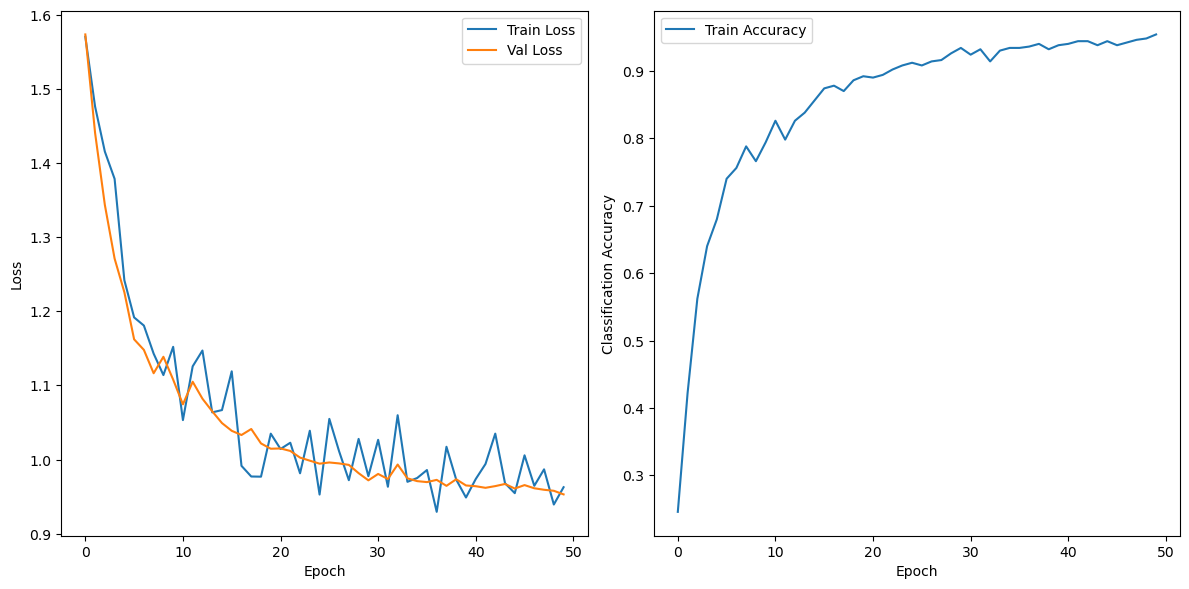

Time taken: 226.1418 seconds


In [43]:
import time

# Training the model
num_epochs = 100 # Number of epochs to run
max_loss=0.955 # The loss value to carry out early stopping
start_time = time.time() # Record the start time

trained_model=train_model(100, max_loss, 10, model) # Calling the train function

end_time = time.time() # Record the end time
elapsed_time = end_time - start_time # Calculate the elapsed time
print(f"Time taken: {elapsed_time:.4f} seconds") # Print the elapsed time

## Testing the model

In [44]:
def testing_model(model):
    predicted_values=[] # To store the predicted values for f1 score calculation
    actual_values=[] # To store the actual values for f1 score calculation
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for batch_X, batch_y in test_loader:
            # Making predictions
            outputs = model(batch_X)
            _, predicted = torch.max(outputs, 1)
            total += batch_y.size(0)
            correct += (predicted == batch_y).sum().item()
            predicted_values.append(predicted)
            actual_values.append(batch_y)
        flat_actual = torch.cat(actual_values).cpu().numpy()
        flat_predicted = torch.cat(predicted_values).cpu().numpy()
        f1 = f1_score(flat_actual, flat_predicted, average='weighted')

    test_accuracy = 100 * correct / total
    print(f'Test Accuracy: {test_accuracy:.2f}%, F1 score: {f1:.2f}')


In [45]:
# Testing the model
testing_model(trained_model)

Test Accuracy: 73.80%, F1 score: 0.73


### The validation accuracy is 77.4% while the test accuracy is only 59.2% This means there may be a case of overfitting. Thus, we will try building a neural network with only 2 hidden layers

# Testing model with 2 hidden layers only

In [46]:
class FeedForwardNet2(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, num_classes):
        super(FeedForwardNet2, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden_size2, hidden_size2)
        self.relu3 = nn.ReLU()
        self.fc4 = nn.Linear(hidden_size2, num_classes)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu1(out)
        out = self.fc2(out)
        out = self.relu2(out)
        out = self.fc3(out)
        out = self.relu3(out)
        # Perform mean aggregation
        out = torch.mean(out, dim=1, keepdim=False)
        out = self.fc4(out)
        out = self.softmax(out)
        return out 

In [47]:
max_loss=0.965
model2 = FeedForwardNet2(input_size, hidden_size, hidden_size, num_classes)

trained_model2=train_model(100, max_loss, 100, model2)

Epoch 1/100, Train Loss: 0.0000, Val Loss: 1.6092, Val Accuracy: 24.60%, F1 score: 0.10
Epoch 2/100, Train Loss: 1.6095, Val Loss: 1.6092, Val Accuracy: 24.60%, F1 score: 0.10
Epoch 3/100, Train Loss: 1.6097, Val Loss: 1.6092, Val Accuracy: 24.60%, F1 score: 0.10
Epoch 4/100, Train Loss: 1.6096, Val Loss: 1.6092, Val Accuracy: 24.60%, F1 score: 0.10
Epoch 5/100, Train Loss: 1.6096, Val Loss: 1.6092, Val Accuracy: 24.60%, F1 score: 0.10
Epoch 6/100, Train Loss: 1.6096, Val Loss: 1.6092, Val Accuracy: 24.60%, F1 score: 0.10
Epoch 7/100, Train Loss: 1.6095, Val Loss: 1.6092, Val Accuracy: 24.60%, F1 score: 0.10
Epoch 8/100, Train Loss: 1.6094, Val Loss: 1.6092, Val Accuracy: 24.60%, F1 score: 0.10
Epoch 9/100, Train Loss: 1.6094, Val Loss: 1.6092, Val Accuracy: 24.60%, F1 score: 0.10
Epoch 10/100, Train Loss: 1.6095, Val Loss: 1.6092, Val Accuracy: 24.60%, F1 score: 0.10
Epoch 11/100, Train Loss: 1.6095, Val Loss: 1.6092, Val Accuracy: 24.60%, F1 score: 0.10
Epoch 12/100, Train Loss: 1.60

Epoch 94/100, Train Loss: 1.6094, Val Loss: 1.6092, Val Accuracy: 24.60%, F1 score: 0.10
Epoch 95/100, Train Loss: 1.6094, Val Loss: 1.6092, Val Accuracy: 24.60%, F1 score: 0.10
Epoch 96/100, Train Loss: 1.6094, Val Loss: 1.6092, Val Accuracy: 24.60%, F1 score: 0.10
Epoch 97/100, Train Loss: 1.6094, Val Loss: 1.6092, Val Accuracy: 24.60%, F1 score: 0.10
Epoch 98/100, Train Loss: 1.6094, Val Loss: 1.6092, Val Accuracy: 24.60%, F1 score: 0.10
Epoch 99/100, Train Loss: 1.6094, Val Loss: 1.6092, Val Accuracy: 24.60%, F1 score: 0.10
Epoch 100/100, Train Loss: 1.6094, Val Loss: 1.6092, Val Accuracy: 24.60%, F1 score: 0.10


In [48]:
testing_model(trained_model2)

Test Accuracy: 13.00%, F1 score: 0.03


### It seems that the accuracy has gotten worse, thus the network with 4 hidden layers is still the best

# Testing with a 3 layer neural network

In [52]:
class FeedForwardNet3(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, num_classes):
        super(FeedForwardNet3, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden_size2, hidden_size2)
        self.relu3 = nn.ReLU()
        self.fc4 = nn.Linear(hidden_size2, hidden_size2)
        self.relu4 = nn.ReLU()
        self.fc5 = nn.Linear(hidden_size2, num_classes)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu1(out)
        out = self.fc2(out)
        out = self.relu2(out)
        out = self.fc3(out)
        out = self.relu3(out)
        out = self.fc4(out)
        out = self.relu4(out)
        # Perform mean aggregation
        out = torch.mean(out, dim=1, keepdim=False)
        out = self.fc5(out)
        out = self.softmax(out)
        return out 

In [53]:
batch_size = 128

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.int64)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.int64)
X_val_tensor = torch.tensor(X_dev, dtype=torch.float32)
y_val_tensor = torch.tensor(y_dev, dtype=torch.int64)

# Create data loaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [54]:
input_size = 300  # Size of the word embeddings
hidden_size = 256  # Users are able to adjust the number of hidden neurons
num_classes = 5
max_loss=0.965
model3 = FeedForwardNet3(input_size, hidden_size, hidden_size, num_classes)

trained_model3=train_model(100, max_loss, 100, model3)

Epoch 1/100, Train Loss: 0.0000, Val Loss: 1.6094, Val Accuracy: 21.20%, F1 score: 0.07
Epoch 2/100, Train Loss: 1.6098, Val Loss: 1.6094, Val Accuracy: 21.20%, F1 score: 0.07
Epoch 3/100, Train Loss: 1.6100, Val Loss: 1.6094, Val Accuracy: 21.20%, F1 score: 0.07
Epoch 4/100, Train Loss: 1.6096, Val Loss: 1.6094, Val Accuracy: 21.20%, F1 score: 0.07
Epoch 5/100, Train Loss: 1.6096, Val Loss: 1.6094, Val Accuracy: 21.20%, F1 score: 0.07
Epoch 6/100, Train Loss: 1.6096, Val Loss: 1.6094, Val Accuracy: 21.20%, F1 score: 0.07
Epoch 7/100, Train Loss: 1.6094, Val Loss: 1.6094, Val Accuracy: 21.20%, F1 score: 0.07
Epoch 8/100, Train Loss: 1.6094, Val Loss: 1.6094, Val Accuracy: 21.20%, F1 score: 0.07
Epoch 9/100, Train Loss: 1.6094, Val Loss: 1.6094, Val Accuracy: 21.20%, F1 score: 0.07
Epoch 10/100, Train Loss: 1.6094, Val Loss: 1.6094, Val Accuracy: 21.20%, F1 score: 0.07
Epoch 11/100, Train Loss: 1.6094, Val Loss: 1.6094, Val Accuracy: 21.20%, F1 score: 0.07
Epoch 12/100, Train Loss: 1.60

Epoch 94/100, Train Loss: 1.6093, Val Loss: 1.6094, Val Accuracy: 21.20%, F1 score: 0.07
Epoch 95/100, Train Loss: 1.6092, Val Loss: 1.6094, Val Accuracy: 21.20%, F1 score: 0.07
Epoch 96/100, Train Loss: 1.6093, Val Loss: 1.6094, Val Accuracy: 21.20%, F1 score: 0.07
Epoch 97/100, Train Loss: 1.6093, Val Loss: 1.6094, Val Accuracy: 21.20%, F1 score: 0.07
Epoch 98/100, Train Loss: 1.6093, Val Loss: 1.6094, Val Accuracy: 21.20%, F1 score: 0.07
Epoch 99/100, Train Loss: 1.6093, Val Loss: 1.6094, Val Accuracy: 21.20%, F1 score: 0.07
Epoch 100/100, Train Loss: 1.6093, Val Loss: 1.6094, Val Accuracy: 21.20%, F1 score: 0.07


In [55]:
testing_model(trained_model3)

Test Accuracy: 27.60%, F1 score: 0.12


### It would seem that the feed forward network with 4 hidden layers worked the best, with the highest accuracy score